In [5]:
!pip install bertopic
!pip install sentence-transformers
!pip install umap-learn
!pip install hdbscan
pip install langchain langgraph newspaper3k beautifulsoup4 scikit-learn nltk
pip install newspaper3k googlesearch-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: n

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

После загрузки данных из интернета над их прочистить 

In [3]:
import json
import pandas as pd
import re

with open("/kaggle/input/ai-in-healthcare2-0/ai_healthcare_full_articles.json", "r", encoding="utf-8") as f:
    data = json.load(f)

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # space 
    text = re.sub(r'[^\x00-\x7F]+', ' ', text) # ascii 
    text = text.strip()
    return text

cleaned_data = []
for article in data:
    cleaned_text = clean_text(article["text"])
    if len(cleaned_text.split()) >= 100:
        cleaned_data.append({
            "title": article["title"],
            "url": article["url"],
            "text": cleaned_text
        })

df = pd.DataFrame(cleaned_data)
df.to_csv("data1.csv", index=False, encoding="utf-8")

print(len(df))


32


**здесь начинается Класстеризация**

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

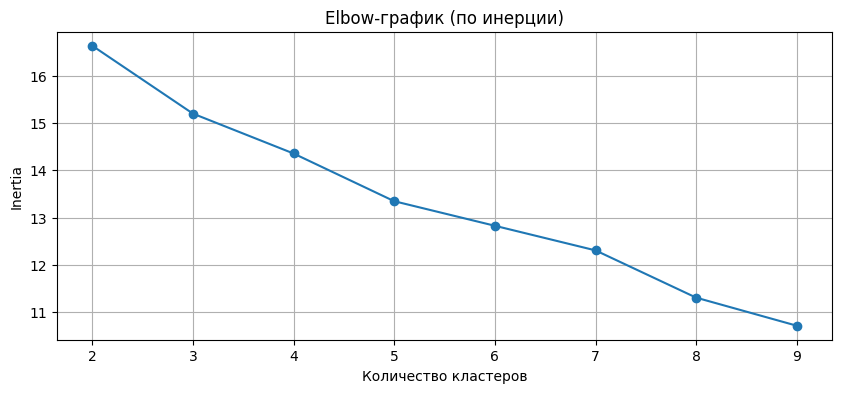

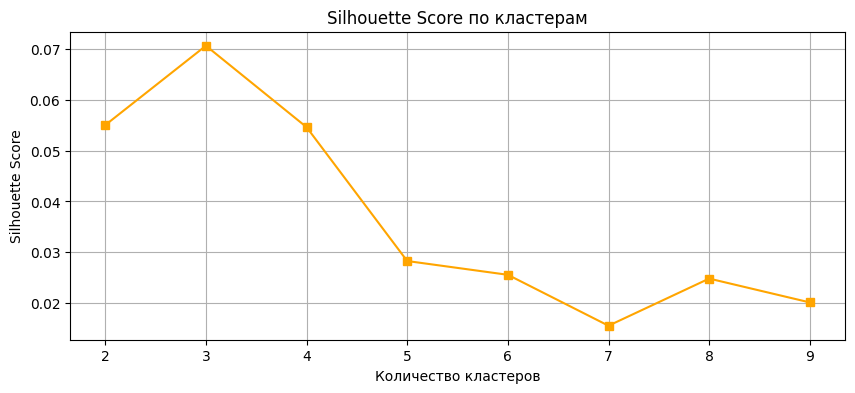

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer

# Загрузка данных
df = pd.read_csv("/kaggle/working/data1.csv")
df.dropna(subset=["text"], inplace=True)

# Векторизация текстов
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(df["text"].tolist(), show_progress_bar=True)

# Elbow-график и Silhouette Score
inertia = []
silhouette_scores = []
cluster_range = range(2, 10)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(embeddings)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(embeddings, labels))

# Визуализация Elbow-графика
plt.figure(figsize=(10, 4))
plt.plot(cluster_range, inertia, marker='o')
plt.title("Elbow-график (по инерции)")
plt.xlabel("Количество кластеров")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

# Визуализация Silhouette Score
plt.figure(figsize=(10, 4))
plt.plot(cluster_range, silhouette_scores, marker='s', color='orange')
plt.title("Silhouette Score по кластерам")
plt.xlabel("Количество кластеров")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


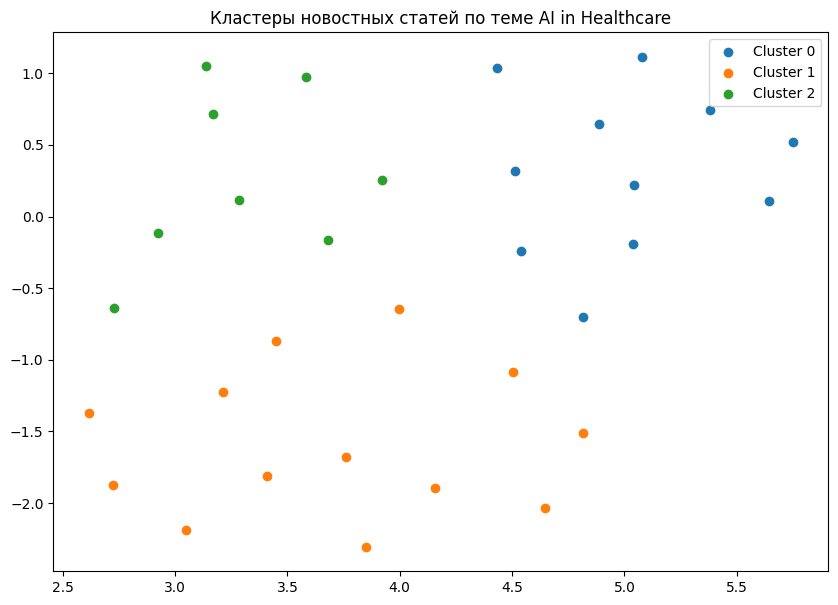

In [7]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import umap
import matplotlib.pyplot as plt

df = pd.read_csv("data1.csv")
texts = df["text"].tolist()

model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(texts, show_progress_bar=True)

umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine')
reduced_embeddings = umap_model.fit_transform(embeddings)

n_clusters = 3  
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(reduced_embeddings)

df["cluster"] = clusters

plt.figure(figsize=(10, 7))
for i in range(n_clusters):
    plt.scatter(reduced_embeddings[clusters == i, 0], reduced_embeddings[clusters == i, 1], label=f"Cluster {i}")
plt.legend()
plt.title("Кластеры новостных статей по теме AI in Healthcare")
plt.show()

df.to_csv("cluster_articles.csv", index=False)


In [1]:
!pip install --upgrade openai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.4/764.4 kB 14.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: openai
    Found existing installation: openai 1.91.0
    Uninstalling openai-1.91.0:
      Successfully uninstalled openai-1.91.0


In [19]:
import pandas as pd
import openai
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

openai.api_key = "b166e4608c2c0182ee202612162726657a719a401752eaa25db5c50fba1ae6fc"
openai.base_url = "https://api.together.xyz/v1"

df = pd.read_csv("data1.csv")
texts = df["text"].astype(str).tolist()

# 
num_clusters = 3
vectorizer = TfidfVectorizer(stop_words="english", max_df=0.8)
X = vectorizer.fit_transform(texts)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(X)
df["cluster"] = labels

def generate_summary(texts, model="mistralai/Mixtral-8x7B-Instruct-v0.1"):
    from openai import OpenAI
    client = OpenAI(
        api_key=openai.api_key,
        base_url=openai.base_url,
    )
    
    chunk = "\n\n".join(texts[:3])[:4000]
    messages = [
        {
            "role": "user",
            "content": f"Summarize the following news articles into a coherent summary:\n\n{chunk}\n\nSummary:"
        }
    ]
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=800,
        temperature=0.7
    )
    return response.choices[0].message.content.strip()

summaries = []

for i in range(num_clusters):
    cluster_texts = df[df["cluster"] == i]["text"].tolist()
    print(f"\n Кластер {i}: {len(cluster_texts)} статей")
    try:
        summary = generate_summary(cluster_texts)
        summaries.append((i, summary))
        print(f"Готово: кластер {i}")
    except Exception as e:
        print(f" Ошибка {i}: {e}")

# Сохранение
with open("cluster_summaries.txt", "w", encoding="utf-8") as f:
    for cid, summary in summaries:
        f.write(f"### Cluster {cid}\n{summary}\n\n")


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



 Кластер 0: 16 статей
Готово: кластер 0

 Кластер 1: 5 статей
Готово: кластер 1

 Кластер 2: 11 статей
Готово: кластер 2


In [23]:
import os
from openai import OpenAI

client = OpenAI(
    api_key="b166e4608c2c0182ee202612162726657a719a401752eaa25db5c50fba1ae6fc", 
    base_url="https://api.together.xyz/v1"
)

with open("cluster_summaries.txt", "r", encoding="utf-8") as f:
    cluster_texts = f.read()

clusters = cluster_texts.strip().split("\n\n")
chunks = [clusters[i::3] for i in range(3)]  

meta_article_parts = []

for i, chunk in enumerate(chunks):
    chunk_text = "\n\n".join(chunk)
    prompt = (
        f"Ты научный писатель. Напиши связную, академическую часть мета-статьи по теме "
        f"'AI in Healthcare', используя следующие тематические резюме:\n\n"
        f"{chunk_text}\n\n"
        f"Требования:\n"
        f"- Стиль: академический английский.\n"
        f"- Объём: ~2000–2500 слов.\n"
        f"- Используй заголовки и подзаголовки.\n"
        f"- Избегай повторов, обеспечь логичность и плавные переходы.\n"
        f"- Это часть {i+1} из 3, не делай выводов — они будут в конце общей статьи.\n"
    )

    response = client.chat.completions.create(
        model="mistralai/Mixtral-8x7B-Instruct-v0.1",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7,
        max_tokens=4096,
    )

    part = response.choices[0].message.content.strip()
    meta_article_parts.append(part)

    with open(f"meta_article_part{i+1}.txt", "w", encoding="utf-8") as f:
        f.write(part)

with open("meta_article_full.txt", "w", encoding="utf-8") as f:
    for part in meta_article_parts:
        f.write(part + "\n\n")

print(" meta_article_full.txt")


 Финальная мета-статья сохранена в meta_article_full.txt
